# The Method

In [1]:
!pip install activeSVC==1.0.1


In [ ]:
import numpy as np
import time
import random
import os

from sklearn.preprocessing import normalize 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import gridspec

from activeSVC import min_complexity, min_acquisition
import pandas as pd
import pickle

def text_create(path, name, msg):
    full_path = path + "/" + name + '.txt'
    file = open(full_path, 'w')
    file.write(str(msg))

class TimerError(Exception):
     """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Total run time: {elapsed_time:0.4f} seconds")
        



# Download and Load PBMC Data

In [ ]:
import urllib.request
import shutil

with urllib.request.urlopen("https://caltech.box.com/shared/static/wqvm0d9irzb7tneb16q01fnr4dt6cvl0.csv") as response, open('./PBMCnorm_final.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)

with urllib.request.urlopen("https://caltech.box.com/shared/static/mxnl3tu0p8ta6zehdutjg8vxpppv3t8v.csv") as response, open('./labels_final.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)

with urllib.request.urlopen("https://caltech.box.com/shared/static/mysl5kjfq6p87ib7zygrpc61b8jyxt3g.csv") as response, open('./genes_final.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)


In [ ]:
data_df = pd.read_csv('./PBMCnorm_final.csv')
label_df=pd.read_csv('./labels_final.csv',header = None)
gene_df=pd.read_csv('./genes_final.csv')
classes=[0,1,2,3,4]
keys=['Monocytes','T cells','Act. T/NK','B cells','Others']

raw_data=data_df.values
target=label_df.values.reshape((raw_data.shape[1],)).astype(np.uint8)-1
gene=gene_df.values.reshape((raw_data.shape[0],))
data=normalize(np.transpose(raw_data),axis=1, norm='l2')
del data_df,label_df,gene_df,raw_data


idx = np.arange(np.shape(data)[0])
random.shuffle(idx)
X_train = data[idx[:int(np.shape(data)[0]*4/5)],:]
y_train = target[idx[:int(np.shape(data)[0]*4/5)]]
X_test = data[idx[int(np.shape(data)[0]*4/5):],:]
y_test = target[idx[int(np.shape(data)[0]*4/5):]]

print(type(data))
print(np.shape(data),np.shape(target),len(np.unique(target)))
print(np.shape(X_train))
print(np.shape(X_test))
for i in np.unique(target):
    print('class '+keys[i]+': '+str(np.count_nonzero((target==i)*1)))

<class 'numpy.ndarray'>
(10194, 6915) (10194,) 5
(8155, 6915)
(2039, 6915)
class Monocytes: 3269
class T cells: 3517
class Act. T/NK: 1265
class B cells: 995
class Others: 1148


# min_complexity

## Define Parameters and Work Space

In [ ]:
'''
Parameters
'''
num_features = 15
num_samples=20
init_samples=100
balance=False

folder='results/min_complexity'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory results failed
Creation of the directory results/min_complexity failed
Successfully created the directory results/min_complexity/test_15_20 


## Select Genes and Save Results

feature 0 : gene 452  100 samples
training error=2.124218270999387 test error=2.1078960274644434
training accuracy=0.5655426118945432 test accuracy=0.5644923982344286
Elapsed time: 3.9960 seconds
feature 1 : gene 2232  120 samples
training error=1.7930104230533415 test error=1.7709661598822952
training accuracy=0.7009196811771919 test accuracy=0.6988719960765081
Elapsed time: 3.9858 seconds
feature 2 : gene 5475  140 samples
training error=1.6213366033108523 test error=1.550760176557136
training accuracy=0.7887185775597793 test accuracy=0.7871505640019617
Elapsed time: 3.8657 seconds
feature 3 : gene 2230  159 samples
training error=1.6095646842427958 test error=1.5291809710642472
training accuracy=0.7961986511342735 test accuracy=0.7969592937714566
Elapsed time: 4.0721 seconds
feature 4 : gene 5015  179 samples
training error=1.5900674432863273 test error=1.5125061304561058
training accuracy=0.8 test accuracy=0.7989210397253556
Elapsed time: 4.1028 seconds
feature 5 : gene 209  199 sa

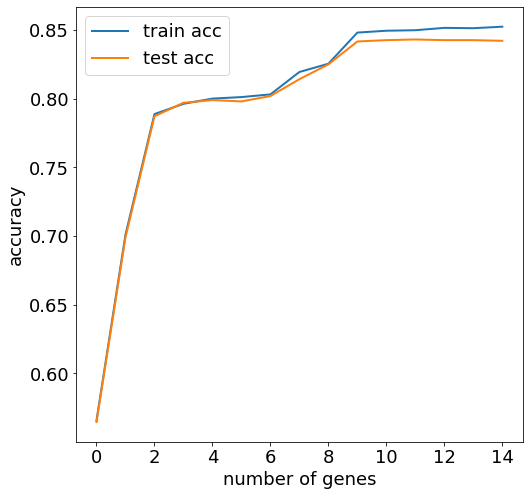

In [ ]:
if __name__ == '__main__':

    t=Timer()
    t.start()
    feature_selected, num_samples_list, train_errors,test_errors,train_scores,test_scores= min_complexity(
        X_train,y_train,X_test,y_test,num_features=num_features,num_samples=num_samples,init_samples=init_samples, balance=balance)
    t.stop()

    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'genes_name',gene[feature_selected])

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

# min_aquisition

## Define Parameters and Work Space

In [ ]:
'''
Parameters
'''
num_features = 15
num_samples=50
init_samples=100

folder='results/min_acquisition'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory results failed
Creation of the directory results/min_acquisition failed
Creation of the directory results/min_acquisition/test_15_50 failed


## Select Genes and Save Results

feature 0 : gene 6064  100 samples
training error=2.1587982832618025 test error=2.1020107896027462
training accuracy=0.632618025751073 test accuracy=0.6277587052476704
Elapsed time: 7.3786 seconds
feature 1 : gene 2232  116 samples
training error=1.7917841814837523 test error=1.7184894556154977
training accuracy=0.7205395462906192 test accuracy=0.7194703285924473
Elapsed time: 8.2138 seconds
feature 2 : gene 2230  130 samples
training error=1.7373390557939914 test error=1.6365865620402158
training accuracy=0.7308399754751687 test accuracy=0.7312408043158412
Elapsed time: 8.3135 seconds
feature 3 : gene 1829  130 samples
training error=1.6129981606376456 test error=1.4884747425208436
training accuracy=0.7554874310239117 test accuracy=0.7528200098087298
Elapsed time: 8.6517 seconds
feature 4 : gene 5475  136 samples
training error=1.4999386879215206 test error=1.3604708190289359
training accuracy=0.8212139791538933 test accuracy=0.8200098087297695
Elapsed time: 9.1814 seconds
feature 5 :

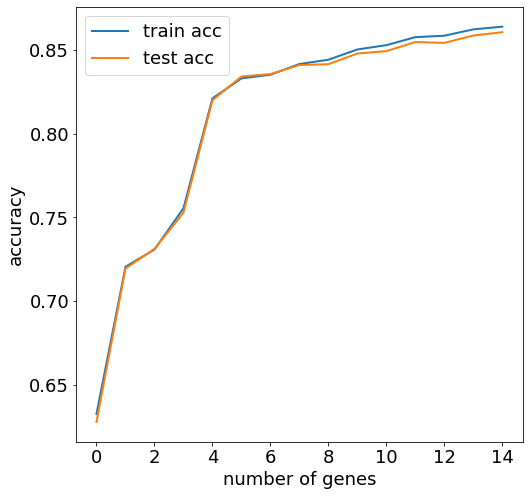

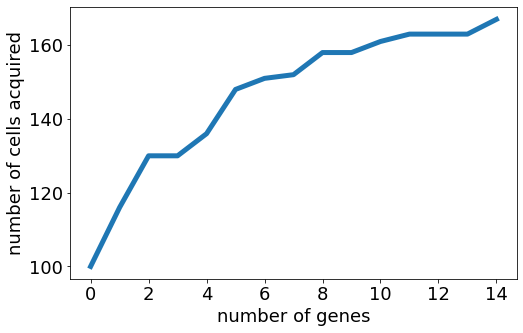

In [ ]:
if __name__ == '__main__':

    t=Timer()
    t.start()
    feature_selected, num_samples_list, samples_global, train_errors,test_errors,train_scores,test_scores= min_acquisition(
        X_train,y_train,X_test,y_test,num_features=num_features,num_samples=num_samples, init_samples=init_samples)
    t.stop()

    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'samples_global',samples_global)
    text_create(path,'genes_name',gene[feature_selected])

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

    plt.figure(figsize=(8,5))
    plt.plot(num_samples_list,linewidth=5)
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('number of cells acquired',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/cells.pdf', bbox_inches="tight")

# T-SNE of Results

## T-SNE of Original Dataset

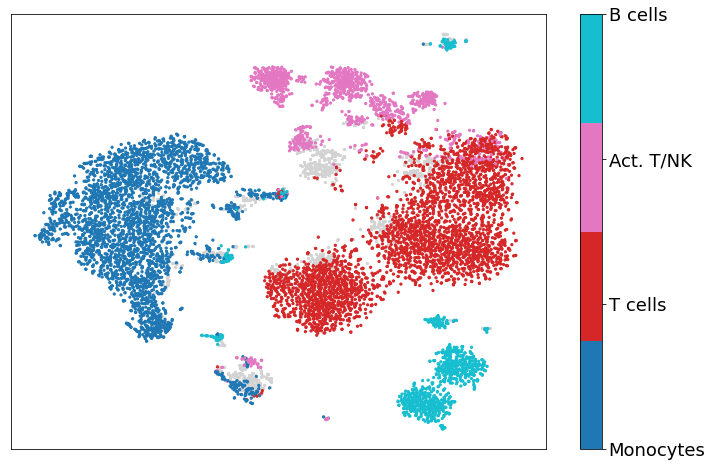

In [ ]:
plt.figure(figsize=(12,8))

pca=PCA(n_components=int(X_train.shape[1]/100),
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data)

Y=TSNE(n_components=2).fit_transform(pcaproj)

others=list(np.where(target==4)[0])
cells=list(np.where(target!=4)[0])

c_cmap = plt.get_cmap('tab10', len(classes)-1)
plt.scatter(Y[others,0], Y[others,1], c='lightgray', s=5)
plt.scatter(Y[cells,0],Y[cells,1],c=target[cells],s=5,cmap=c_cmap)
cbar=plt.colorbar(ticks=np.arange(len(classes)-1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys[:-1],fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne.pdf',bbox_inches="tight")

f=open(path+'/tsne.pickle','wb') 
pickle.dump(Y,f)
f.close()

## T-SNE with All Genes Selected

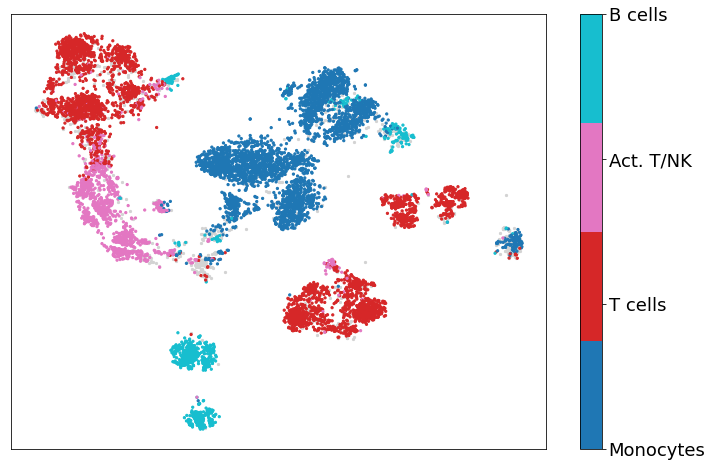

In [ ]:
plt.figure(figsize=(12,8))
data_selected=data[:,feature_selected]

pca=PCA(n_components=7,
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data_selected)

Y_selected=TSNE(n_components=2,perplexity=200,early_exaggeration=1).fit_transform(pcaproj)

others=list(np.where(target==4)[0])
cells=list(np.where(target!=4)[0])

c_cmap = plt.get_cmap('tab10', len(classes)-1)
plt.scatter(Y_selected[others,0], Y_selected[others,1], c='lightgray', s=5)
plt.scatter(Y_selected[cells,0],Y_selected[cells,1],c=target[cells],s=5,cmap=c_cmap)
cbar=plt.colorbar(ticks=np.arange(len(classes)-1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys[:-1],fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne_selected_wPCA.pdf',bbox_inches="tight")

f=open(path+'/tsne_selected_wPCA.pickle','wb') 
pickle.dump(Y_selected,f)
f.close()

## T-SNE of Each Gene

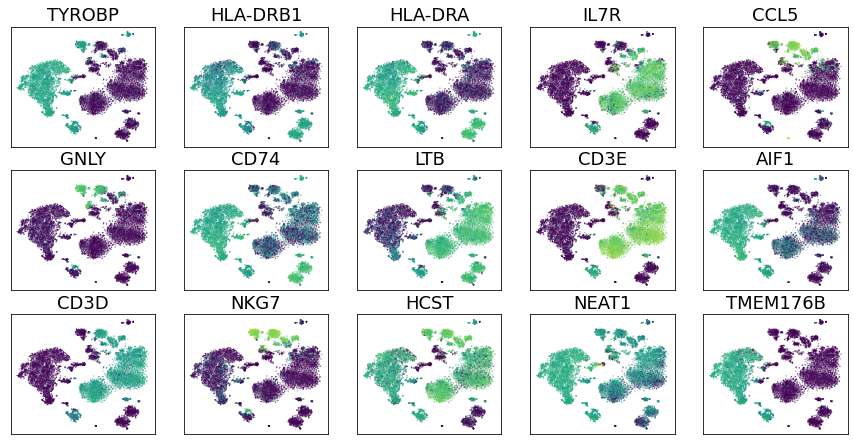

In [ ]:
alpha = 100
data_show = np.log1p(data*alpha)

size=len(feature_selected)
plt.figure(figsize=(15,2.5*int(size/5)))
gs = gridspec.GridSpec(int(size/5), 5, width_ratios=[7,7,7,7,7])

for i in range(size):
    f=feature_selected[i]
    ax0 = plt.subplot(gs[i])
    ax0.set_title(gene[f],fontdict={'weight':'normal','size': 18})
    plt.scatter(Y[:,0],Y[:,1],c=data_show[:,f],s=0.05)
    ax0.set_xticks([])
    ax0.set_yticks([])
plt.savefig(path+'/gene.png',dpi=300,  bbox_inches="tight")    